Target : ADD LR Scheduler 

Result : Params : 8,828
         Best Train ACC:99.29%
         Best Test ACC:99.48%

Analysis : Accuracy Target reached.


In [ ]:
!pip install torchsummary

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01)
        )
        #28/26/3
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01)
        )
        #26/24/5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01)
        )
        #24/22/7

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.01)
        )
        #22/20/9
        self.pool = nn.MaxPool2d(2, 2)
        #20/10/10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=14, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(0.01)
        )
        #10/8/14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(0.01)
        )
        #8/6/18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.01)
        )
        #6/6/18
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
           Conv2d-13           [-1, 18, 20, 20]           2,610
             ReLU-14           [-1, 18,

In [ ]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    average_epoch_loss = 0
    correct_predictions_epoch = 0
    model.train()
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            tepoch.set_description(f"Train Epoch {epoch}")
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            average_epoch_loss += loss.item()
            correct_predictions = sum(output.argmax(dim = 1) == target)
            correct_predictions_epoch += correct_predictions
            tepoch.set_postfix(loss = round(loss.item(),5), accuracy = format(100 *correct_predictions.item()/data.shape[0], '.4f'))
    return average_epoch_loss/batch_idx,correct_predictions_epoch/len(train_loader.dataset)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def test(model, device, test_loader):
    average_epoch_loss = 0
    correct_predictions_epoch = 0
    model.eval()
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            for batch_idx, (data, target) in enumerate(tepoch):
                tepoch.set_description(f"Test  Epoch {epoch}")
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = F.nll_loss(output, target)  # sum up batch loss
                average_epoch_loss += loss.item()
                correct_predictions = sum(output.argmax(dim = 1) == target)  # get the index of the max log-probability
                correct_predictions_epoch += correct_predictions
                tepoch.set_postfix(loss = round(loss.item(),5), accuracy = format(100 *correct_predictions.item()/data.shape[0], '.4f'))
    return average_epoch_loss/batch_idx,correct_predictions_epoch/len(test_loader.dataset)

In [ ]:
from torch.optim.lr_scheduler import StepLR

# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01,momentum = 0.09)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.15)
# train_loss = []
# test_loss = []

# train_accuracy = []
# test_accuracy = []
# for epoch in range(1, 15):

#     tr_loss,tr_acc = train(model, device, train_loader, optimizer, epoch)
#     scheduler.step()
#     tst_loss,tst_acc = test(model, device, test_loader)
#     train_loss.append(tr_loss),train_accuracy.append(tr_acc)
#     test_loss.append(tst_loss),test_accuracy.append(tst_acc)
#     print("Train_epoch : ",100*tr_acc.item())
#     print("Test_epoch : ",100*tst_acc.item())


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.15)
train_loss = []
test_loss = []

train_accuracy = []
test_accuracy = []
for epoch in range(1, 16):

    tr_loss,tr_acc = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    tst_loss,tst_acc = test(model, device, test_loader)
    train_loss.append(tr_loss),train_accuracy.append(tr_acc)
    test_loss.append(tst_loss),test_accuracy.append(tst_acc)
    print("Train_epoch : ",100*tr_acc.item())
    print("Test_epoch : ",100*tst_acc.item())



Train_epoch :  94.36833262443542
Test_epoch :  97.63000011444092



Train_epoch :  97.9283332824707
Test_epoch :  98.70999455451965



Train_epoch :  98.31500053405762
Test_epoch :  98.81999492645264



Train_epoch :  98.56500029563904
Test_epoch :  99.00999665260315



Train_epoch :  98.72666597366333
Test_epoch :  99.06999468803406



Train_epoch :  99.02166724205017
Test_epoch :  99.34999942779541



Train_epoch :  99.14000034332275
Test_epoch :  99.44999814033508



Train_epoch :  99.17333722114563
Test_epoch :  99.39000010490417



Train_epoch :  99.21166896820068
Test_epoch :  99.39999580383301



Train_epoch :  99.19166564941406
Test_epoch :  99.41999912261963



Train_epoch :  99.23999905586243
Test_epoch :  99.48999881744385



Train_epoch :  99.23666715621948
Test_epoch :  99.44999814033508



Train_epoch :  99.25333261489868
Test_epoch :  99.46999549865723



Train_epoch :  99.25333261489868
Test_epoch :  99.42999482154846



Train_epoch :  99.29167032241821
Test_epoch :  99.42999482154846


In [ ]:
def inference(model, device, test_loader):
    wrong_predictions_epoch = []
    model.eval()
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            for batch_idx, (data, target) in enumerate(tepoch):
                tepoch.set_description(f"Test  Epoch {epoch}")
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = F.nll_loss(output, target)  # sum up batch loss
                wrong_predictions = data[output.argmax(dim = 1) != target]  # get the index of the max log-probability
                wrong_predictions_epoch += wrong_predictions.to("cpu")
                # tepoch.set_postfix(loss = round(loss.item(),5), accuracy = format(100 *correct_predictions.item()/data.shape[0], '.4f'))
    return wrong_predictions_epoch

In [ ]:
wrong_pred = inference(model, device, test_loader)

In [ ]:
import torchvision
import matplotlib.pyplot as plt


In [ ]:
plt.figure(figsize=[20, 20])
grid = torchvision.utils.make_grid(wrong_pred, nrow=50)

<Figure size 1440x1440 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


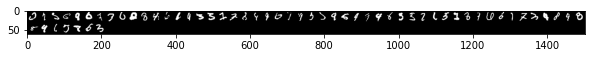

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 50]
plt.imshow(grid.permute(1, 2, 0))